### 0. Installing Libraries

In [1]:
# keras and tensorflow version might be wrong, so we need to down/upgrade
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

shell_call("pip install tensorflow==2.10.0 tensorflow-probability==0.16 keras==2.10.0")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 97.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 59.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.20.1
    Uninstalling ten

In [2]:
if(!require(deepregression)){
  install.packages("deepregression")
  library(deepregression)
}
# note: this also loads tensorflow and keras (both required in the folllowing)

if (!require("imager")) {
  install.packages("imager")
  library(imager)
}

Loading required package: deepregression

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘deepregression’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘config’, ‘tfautograph’, ‘zeallot’, ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘tensorflow’, ‘tfprobability’, ‘keras’, ‘reticulate’, ‘tfruns’


Loading required package: tensorflow

Loading required package: tfprobability

Loading required package: keras

Loading required package: imager

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘imager’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bmp’, ‘tiff’, ‘jpeg’, ‘readbitmap’, ‘downloader’, ‘igraph’


Loading required package: magrittr


Attaching package: ‘imager’


The following object is m

### 1. Auto Differentiation using TensorFlow

First, a more simple example where we automatically calculate $\frac{\partial f(x)}{\partial x}$ where $f(x) = x^2$.

In [3]:
# Define a quadratic function f(x) = x^2
# (or any other that is differentiable)
f <- function(x) {
  x^2
}

# Create a scalar variable
x <- tf$Variable(3.0)

# Record the operations to compute the gradient
with(tf$GradientTape() %as% tape, {
  y <- f(x)
})

# Compute the gradient of y with respect to x
grad <- tape$gradient(y, x) # i.e. dy/dx

# Output the gradient -> should be 2*x = 2*3 = 6
print(grad$numpy())

[1] 6


Let's try a bit more complicated function and see if it still works...

In [4]:
f <- function(X) {
  tf$sqrt(tf$reduce_sum(tf$sinh(X)^2))
}

# Create a 3D variable tensor (an array)
X <- tf$Variable(array(c(1,2,3,4,5,6), dim=c(2,1,3)))

# Record the operations with GradientTape
with(tf$GradientTape() %as% tape, {
  z <- f(X)
})

# Compute gradient
grad_X <- tape$gradient(z, X)

# Print the original 3D tensor and its gradient
cat('Original 3D tensor X:\n')
print(X$numpy())
cat('\nGradient of f w.r.t. X:\n')
print(grad_X$numpy())

Original 3D tensor X:
, , 1

     [,1]
[1,]    1
[2,]    2

, , 2

     [,1]
[1,]    3
[2,]    4

, , 3

     [,1]
[1,]    5
[2,]    6


Gradient of f w.r.t. X:
, , 1

            [,1]
[1,] 0.008359933
[2,] 0.062903411

, , 2

          [,1]
[1,] 0.4649499
[2,] 3.4355620

, , 3

          [,1]
[1,]  25.38556
[2,] 187.57535



So we just computed a derivative w.r.t. an array (!) with no effort.

### 2. Example for Gradient Descent Optimization using the Gradient Tape

In [65]:
library(tensorflow)

# Define a quadratic function f(x) = x^2
f <- function(theta) {
  theta^2
}

# Create a scalar variable
theta <- tf$Variable(5.0)

# Define a learning rate
lr <- 0.1

# Perform gradient descent
for (i in 1:10) {
  with(tf$GradientTape() %as% tape, {
    y <- f(theta)
  })

  # Compute the gradient of y with respect to theta
  grad <- tape$gradient(y, theta)

  # Update theta: theta <- theta - lr * grad
  theta$assign_sub(lr * grad)

  # Print the current theta and y
  cat('Step', i, ':', 'theta =', theta$numpy(), ', y =', y$numpy(), '\n')
}


Step 1 : theta = 4 , y = 25 
Step 2 : theta = 3.2 , y = 16 
Step 3 : theta = 2.56 , y = 10.24 
Step 4 : theta = 2.048 , y = 6.5536 
Step 5 : theta = 1.6384 , y = 4.194304 
Step 6 : theta = 1.31072 , y = 2.684354 
Step 7 : theta = 1.048576 , y = 1.717986 
Step 8 : theta = 0.8388607 , y = 1.099511 
Step 9 : theta = 0.6710886 , y = 0.7036873 
Step 10 : theta = 0.5368708 , y = 0.4503599 


### 3. Optimizing Neural Networks in `keras`

- We start with a Multi-layer perceptron (a network with fully connected layers)
- We use the MNIST data as an example, which we first load (incl. in keras)


In [6]:
# Load the MNIST dataset
mnist <- dataset_mnist()
x_train <- mnist$train$x
y_train <- mnist$train$y
x_test <- mnist$test$x
y_test <- mnist$test$y

We can visualize the data e.g. as follows:

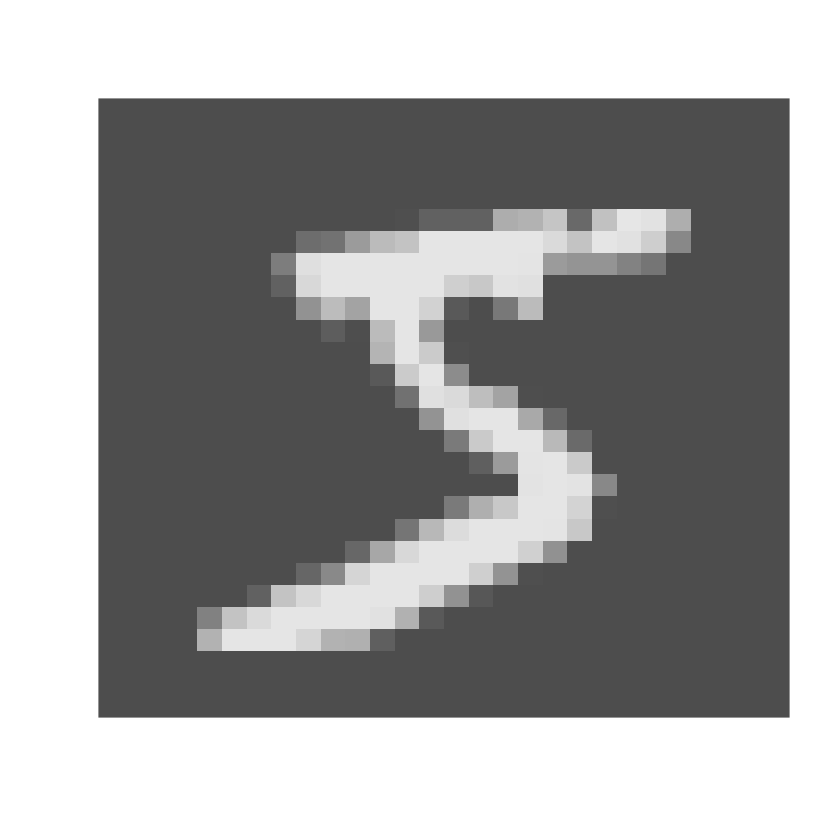

In [7]:
# Choose the first image
img <- x_train[1,,]

# Visualize the image
image(t(apply(img, 2, rev)), col = grey.colors(255), axes = FALSE)

As we have not yet learned the details of convolutional layers, we start by
converting the images into long vectors (i.e. we use every pixel as a feature)

In [8]:
# Preprocess the data
x_train <- array_reshape(x_train, c(nrow(x_train), 784)) / 255
x_test <- array_reshape(x_test, c(nrow(x_test), 784)) / 255
y_train <- to_categorical(y_train, 10)
y_test <- to_categorical(y_test, 10)

We can now define the network and train it using the `keras` functionalities:
- `keras_model_sequential`: sets up a very simply sequential model (i.e. one layers follows the other)
- `compile`: compiles / initializes the model (computes gradients etc.)
- `fit`: runs the optimization (loop over epochs, batches and update weights using the optimizer)

In [9]:
# Define MLP model
model_mlp <- keras_model_sequential() %>%
  layer_dense(units = 256, activation = 'relu', input_shape = c(784)) %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 10, activation = 'softmax')

# Compile the model
model_mlp %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_adam(),
  metrics = c('accuracy')
)

# Train the model
history_mlp <- model_mlp %>% fit(
  x_train, y_train, # the data required
  epochs = 10, # only run for 10 epochs -- probably not enough
  batch_size = 128, # batch size
  validation_split = 0.2, # data percentage to validate model performance
  verbose = FALSE # set to TRUE to see details
)

We can visualize the optimization process as follows:

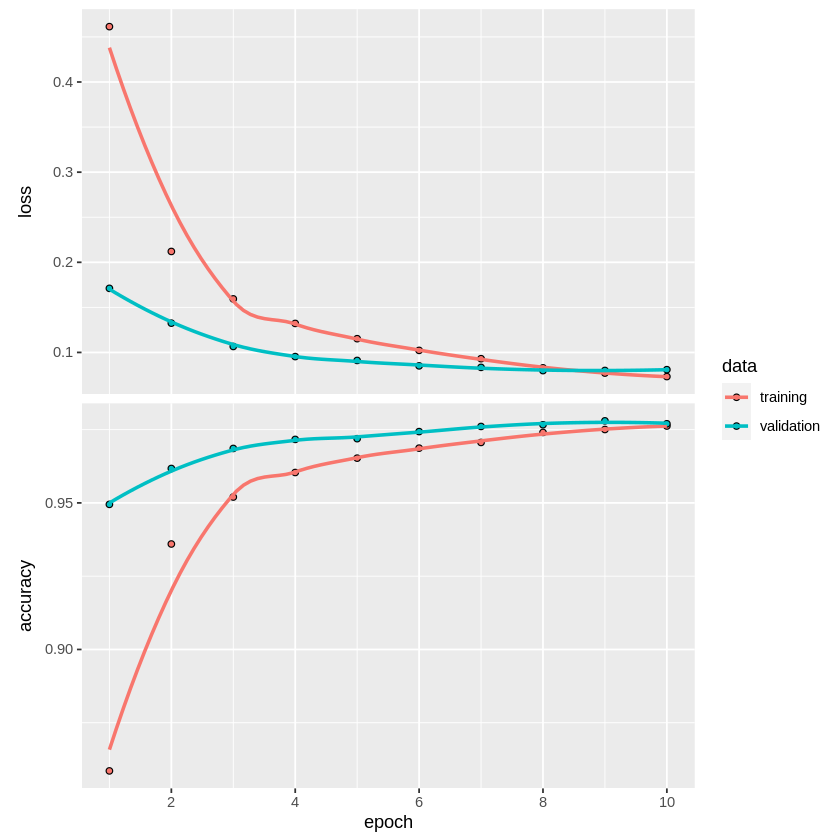

In [10]:
plot(history_mlp)

We can also evaluate the performance on an independent data set

In [11]:
# Evaluate performance
model_mlp %>% evaluate(x_test, y_test)

loss   accuracy 
0.07079362 0.97960001

### 4. Optimizing Statistical Models in Neural Networks

Let's try to fit a logistic regression in a neural network and compare with `glm`

In [12]:
# Load dataset from UCI Machine Learning Repository
url <- "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data <- read.csv(url, header = FALSE)
data[,1:8] <- lapply(data[,1:8], scale)

# Rename columns
names(data) <- c("Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
                 "BMI", "DiabetesPedigreeFunction", "Age", "Outcome")

# Using glm for logistic regression
glm_model <- glm(Outcome ~ ., family = binomial(), data = data)

# Predicting and evaluating
probabilities_glm <- predict(glm_model, data, type = "response")
coefs_glm <- coef(glm_model)


In [13]:
# Preprocessing
x <- as.matrix(data[,1:8])
y <- data$Outcome

# Define a single-layer neural network
model <- keras_model_sequential() %>%
  layer_dense(units = 1, activation = "sigmoid", input_shape = ncol(x))

# Compile the model
model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

# Train the model
model %>% fit(
  x, y,
  epochs = 200,
  batch_size = 16,
  validation_split = 0.2,
  callbacks = list(
    # this callback stops as soon as there
    # is no improvement for 10 iterations
    callback_early_stopping(patience = 10,
    restore_best_weights = TRUE)
  )
)

# Predicting and evaluating
probabilities_nn <- model %>% predict(x)
coefs_nn <- model$weights

Let's first compare the predictions

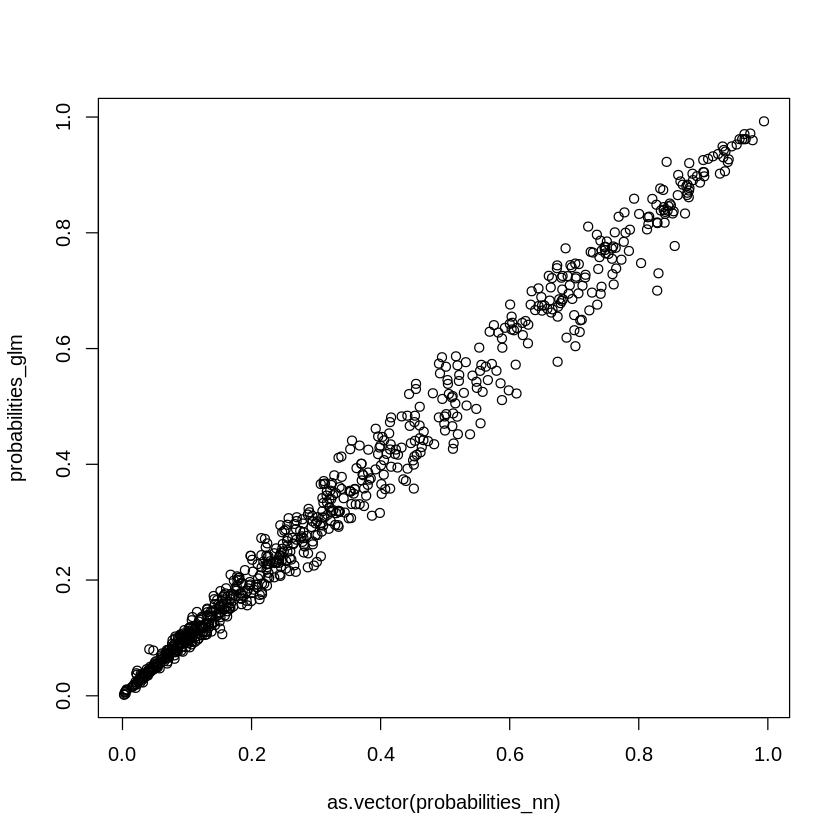

In [14]:
plot(probabilities_glm ~ as.vector(probabilities_nn))

... and compare estimated coefficients

In [15]:
rbind(
  coefs_glm,
  coefs_nn = c(unlist(lapply(coefs_nn, as.matrix)[c(2,1)]))
)


,(Intercept),Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
coefs_glm,-0.8711017,0.4150724,1.124276,-0.2573460,0.009873854,-0.13733616,0.7072168,0.3131651,0.1748629
coefs_nn,-0.8842183,0.3821964,1.010401,-0.2063772,-0.084958337,-0.03059671,0.8287058,0.3576969,0.1556601


### 5. Semi-Structured Networks

Load the AirBnB data

In [16]:
url <- "https://github.com/davidruegamer/airbnb/raw/main/munich_clean_text.RDS"
destfile <- file.path(getwd(), "munich.RDS")
download.file(url, destfile, mode = "wb")
airbnb <- readRDS("munich.RDS")
airbnb$days_since_last_review <- as.numeric(difftime(airbnb$date, airbnb$last_review))

Check if everything worked as intended...

In [17]:
str(airbnb,1)

List of 75
 $ id                                          : num [1:3504] 97945 170154 170815 171749 172672 ...
 $ scrape_id                                   : num [1:3504] 2.02e+13 2.02e+13 2.02e+13 2.02e+13 2.02e+13 ...
 $ last_scraped                                : Date[1:3504], format: "2020-10-26" "2020-10-26" ...
 $ name                                        : chr [1:3504] "Deluxw-Apartm. with roof terrace" "Own floor & bath, parking & breakfast" "Your own flat near central station!" "1min to subway - Wettersteinplatz" ...
 $ description                                 : chr [1:3504] " space br offer modern quiet apartment sunny roof terrace 1 2 persons vicinity hospital grosshadern apartment t"| __truncated__ "enjoy quiet neighbourhood easy access city center attractions public transport free parking privacy breakfast b"| __truncated__ " space br 1 studio appartment kitchen bathroom flat equipped bed flat renovated newly furnished 2019 br br loca"| __truncated__ " apartment l

Let's first fit a generalized additive model using in a neural network

In [18]:
mod_airbnb <- deepregression(y = airbnb$price,
                             list_of_formulas = list(
                               ~ bedrooms + room_type +
                                 s(review_scores_rating),
                               ~ 1
                             ),
                             data = airbnb)
mod_airbnb %>% fit(epochs = 1000,
                   early_stopping = TRUE,
                   patience = 50,
                   verbose = FALSE)

We can visualize the results by, e.g., calling the `plot` function:

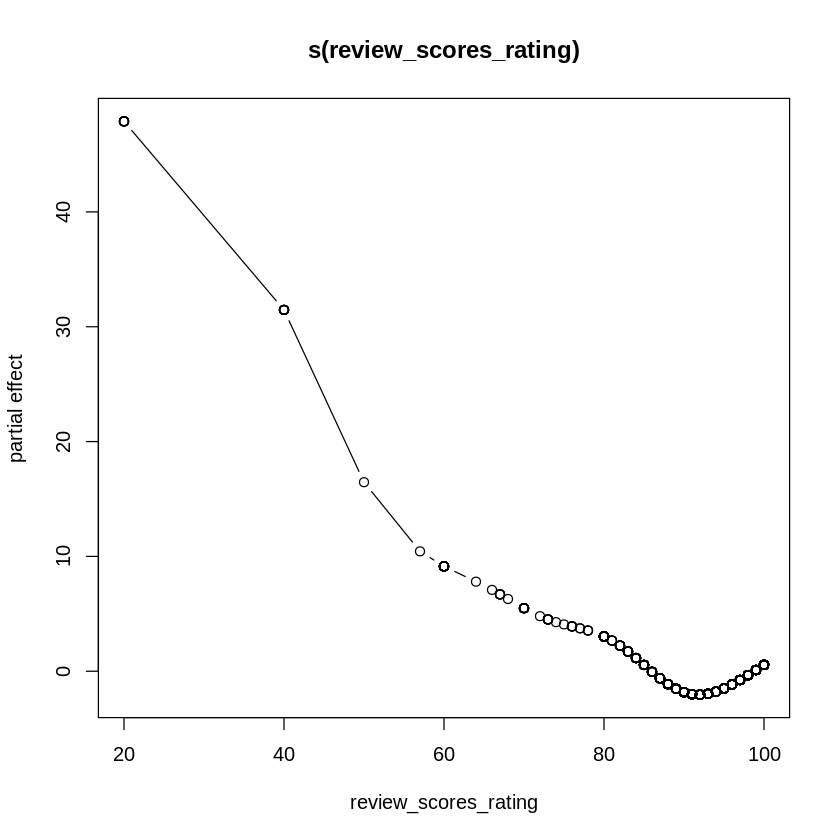

In [19]:
plot(mod_airbnb)

or looking at the estimated coefficients

In [20]:
coef(mod_airbnb)

24.32521820
14.87022591
16.56864357
9.46509933
5.55414200
2.65389585
1.71083629
1.66080189
0.09474695
12.01323
17.28162


Now let's process
- load and pre-process images
- and define suitable models

for defining the semi-structured network that combines the GAM and a convolutional neural network

In [21]:
## pictures
url1 <- "https://github.com/davidruegamer/deepregression_tutorial/raw/main/32_1.zip"
destfile <- file.path(getwd(), "32_1.zip")
download.file(url1, destfile, mode = "wb")
unzip("32_1.zip")
url2 <- "https://github.com/davidruegamer/deepregression_tutorial/raw/main/32_2.zip"
destfile <- file.path(getwd(), "32_2.zip")
download.file(url2, destfile, mode = "wb")
unzip("32_2.zip")

In [22]:
airbnb$image <- paste0(getwd(), "/32/", airbnb$id, ".jpg")

The following code defines a simple convolutional neural network (CNN).
We will talk about some of the details later. For now you can just use this as is.

In [23]:
## -----------------------------------------------------------------------------------------------------
cnn_block <- function(filters, kernel_size, pool_size, rate, input_shape = NULL){
    function(x){
      x %>%
        layer_conv_2d(filters, kernel_size, padding = "same", input_shape = input_shape) %>%
        layer_activation(activation = "relu") %>%
        layer_batch_normalization() %>%
        layer_max_pooling_2d(pool_size = pool_size) %>%
        layer_dropout(rate = rate)
    }
  }


## -----------------------------------------------------------------------------------------------------
cnn <- cnn_block(filters = 16, kernel_size = c(3,3), pool_size = c(3,3), rate = 0.25,
                 shape(200, 200, 3))
deep_model_cnn <- function(x){
    x %>%
    cnn() %>%
    layer_flatten() %>%
    layer_dense(32) %>%
    layer_activation(activation = "relu") %>%
    layer_batch_normalization() %>%
    layer_dropout(rate = 0.5) %>%
    layer_dense(1)
}


Now we define the semi-structured model using the previous deep network

In [73]:
mod_cnn <- deepregression(
  y = log(airbnb$price),
  list_of_formulas = list(
    ~1 + te(latitude, longitude) + # a spatial effect
      deep_model_cnn(image), # a CNN for images
    ~1),
  data = airbnb,
  list_of_deep_models = list(deep_model_cnn =
    list(deep_model_cnn, c(200,200,3))),
  optimizer = optimizer_adam(lr = 0.0001)
)

Warning message in DRO(st[[1]]$margin[[i]]$X, df = this_df[i], dmat = st[[1]]$margin[[i]]$S[[1]], :
“'df' too large:
  Degrees of freedom cannot be larger than the rank of the design matrix.
  Unpenalized base-learner with df = 5 used. Re-consider model specification.”
Warning message in DRO(st[[1]]$margin[[i]]$X, df = this_df[i], dmat = st[[1]]$margin[[i]]$S[[1]], :
“'df' too large:
  Degrees of freedom cannot be larger than the rank of the design matrix.
  Unpenalized base-learner with df = 5 used. Re-consider model specification.”


In [ ]:
# fitting a deepregression model is similar to keras,
# but with some more arguments
mod_cnn %>% fit(
  epochs = 2, # a small number for demonstration purposes
  early_stopping = TRUE, # directly activate early stopping
  patience = 5, # and set the patience
  verbose = FALSE
)

We can now, e.g., check the spatial effect (result is not really meaningful though)

In [ ]:
plot(mod_cnn)

Or make predictions for some pictures:

In [ ]:
image <- load.image(paste0(getwd(), "/32/", airbnb$id[1], ".jpg"))
plot(image)

In [ ]:
# Make the corresponding prediction
summary(log(airbnb$price))
mod_cnn %>% predict(lapply(airbnb[c("image", "latitude", "longitude")],
                    "[[", 1))

In [ ]:
plot(mod_cnn %>% fitted() ~ log(airbnb$price))

### 6. Convolutional Layers

Let's implement the Sobel filter (only it's horizontal part for demonstration) in a keras network!

In [30]:
# Define the Sobel filter kernel for horizontal edge detection
sobel_horizontal <- array(c(-1, 0, 1,
                            -2, 0, 2,
                            -1, 0, 1), dim = c(3, 3, 1, 1))

# Building the model
model <- keras_model_sequential() %>%
  layer_conv_2d(filters = 1, kernel_size = c(3,3), input_shape = c(32,32,1),
                use_bias = FALSE, activation = "relu",
                # plug in the filter values -> normally we would learn these
                # in a data-driven fashion!
                kernel_initializer = initializer_constant(
                  value = sobel_horizontal)
               )

Let's apply the model / filter to an image and see the result:

In [53]:
# Load some examplary data (CIFAR10)
cifar10 <- dataset_cifar10()
x_train <- cifar10$train$x

# Take one image
img <- x_train[2,,,]
img <- array_reshape(img, c(32,32,3))

Warning message in as.cimg.array(img):
“Assuming third dimension corresponds to colour”


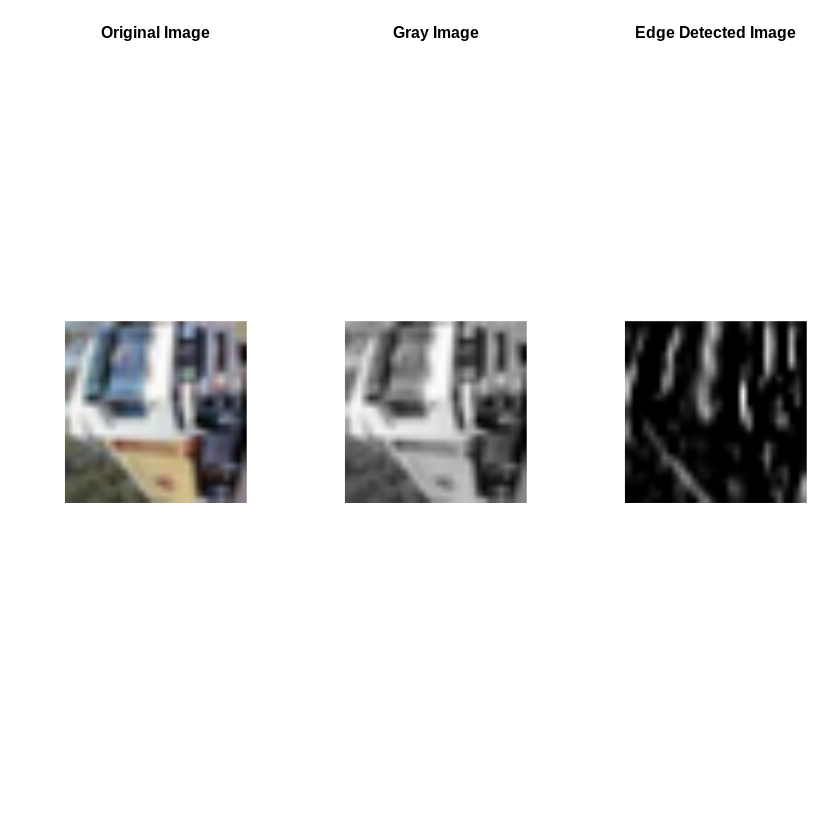

In [58]:
# Convert the image to grayscale using imager
img_imager <- as.cimg(img)
img_gray <- grayscale(img_imager)

# Apply the filter to the image
edge_detected_image <- model %>% predict(
  array_reshape(img_gray/255, c(1, 32, 32, 1)))

# Plotting using imager
layout(matrix(1:3, nrow = 1))
plot(img_imager, axes=FALSE, main="Original Image")
plot(img_gray, axes=FALSE, main="Gray Image")

# Convert the prediction result to an imager image object for plotting
edge_detected_imager <- as.cimg(edge_detected_image[1,,,])

# Plotting the edge-detected image using imager
plot(edge_detected_imager, axes=FALSE, main="Edge Detected Image")

### 7. Recurrent Neural Networks

Let's simulate a small time series and try to predict the next value using a seq-to-one RNN network!

First, generate some synthetic data and plot it:

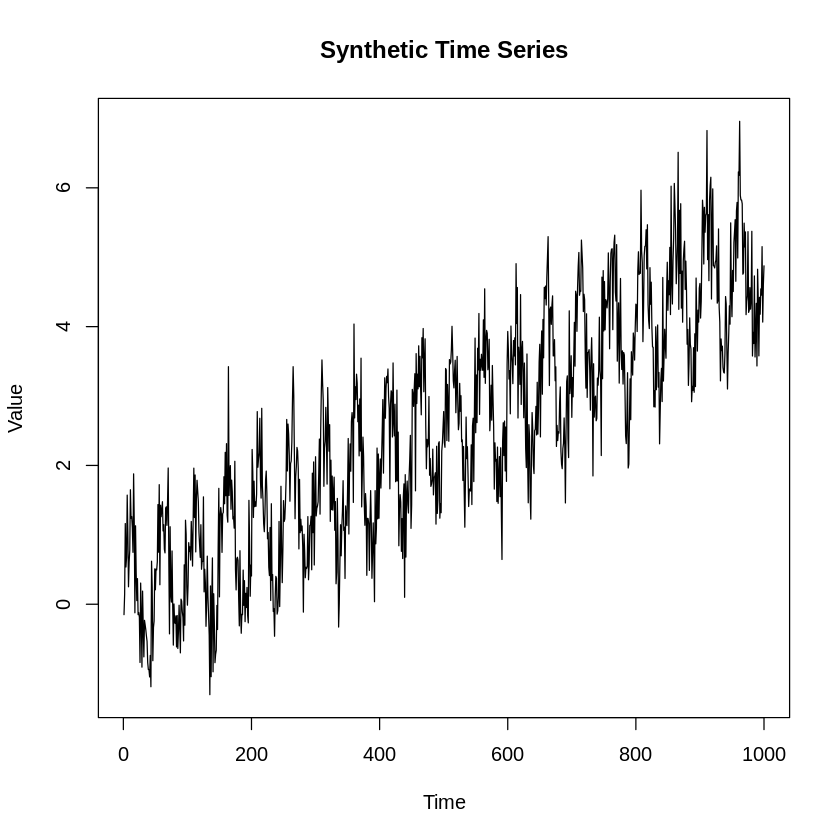

In [59]:
# Set seed for reproducibility
set.seed(123)

# Generate synthetic time series
seq_len <- 1000  # Length of the sequence
x <- seq(1, seq_len)
data <- x/200 + sin(2*pi*x/50) + rnorm(seq_len, sd=0.5)

# Plot original data
plot(x, data, type="l", xlab="Time", ylab="Value", main="Synthetic Time Series")

Next, we prepare the data for model fitting

In [60]:
window_size <- 10  # Consider 10 time steps to predict the next one
x_data <- NULL
y_data <- NULL

for (i in 1:(seq_len - window_size)) {
  x_data <- rbind(x_data, data[i:(i + window_size - 1)])
  y_data <- c(y_data, data[i + window_size])
}

# Reshape data for RNN
x_data <- array_reshape(x_data, c(dim(x_data), 1))
y_data <- array_reshape(y_data, c(length(y_data), 1))


Next, we define our RNN model. We'll use an LSTM layer which is usually better at capturing long-term dependencies than a simple RNN.

Model: "sequential_4"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_1 (LSTM)                      (None, 50)                      10400       
 dense_7 (Dense)                    (None, 1)                       51          
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
________________________________________________________________________________


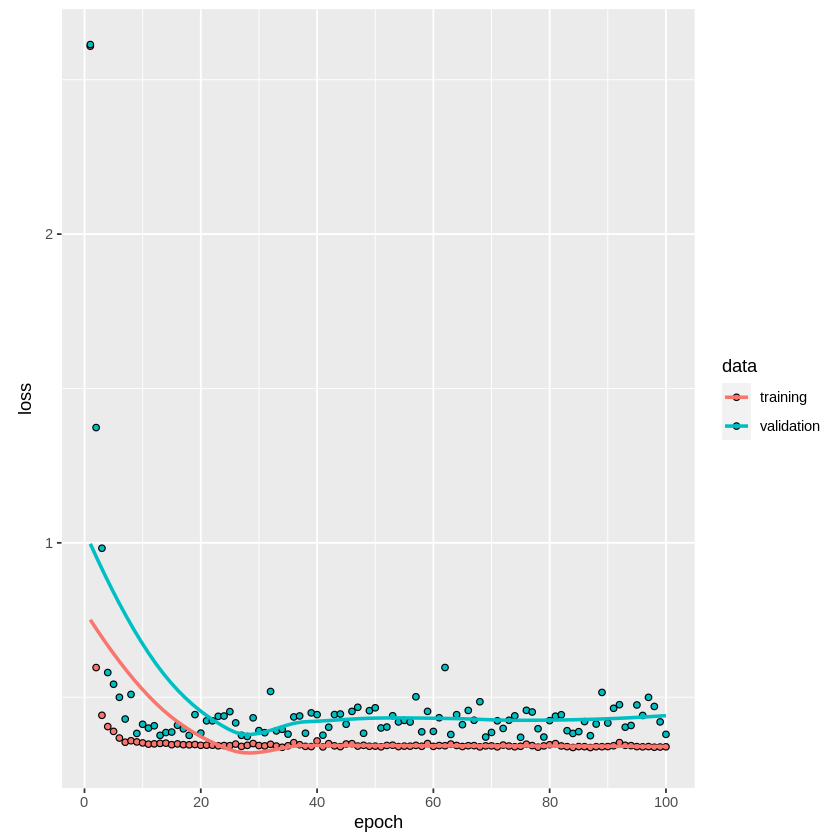

In [63]:
model <- keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = list(window_size, 1)) %>%
  layer_dense(units = 1)

model %>% compile(
  optimizer = optimizer_adam(lr = 0.001),
  loss = "mean_squared_error"
)

summary(model)

### and train the model
history <- model %>% fit(
  x_data, y_data,
  epochs = 100, batch_size = 20,
  validation_split = 0.2,
  shuffle = TRUE
)

# Plotting loss
plot(history)


Finally, we check how well we can predict:

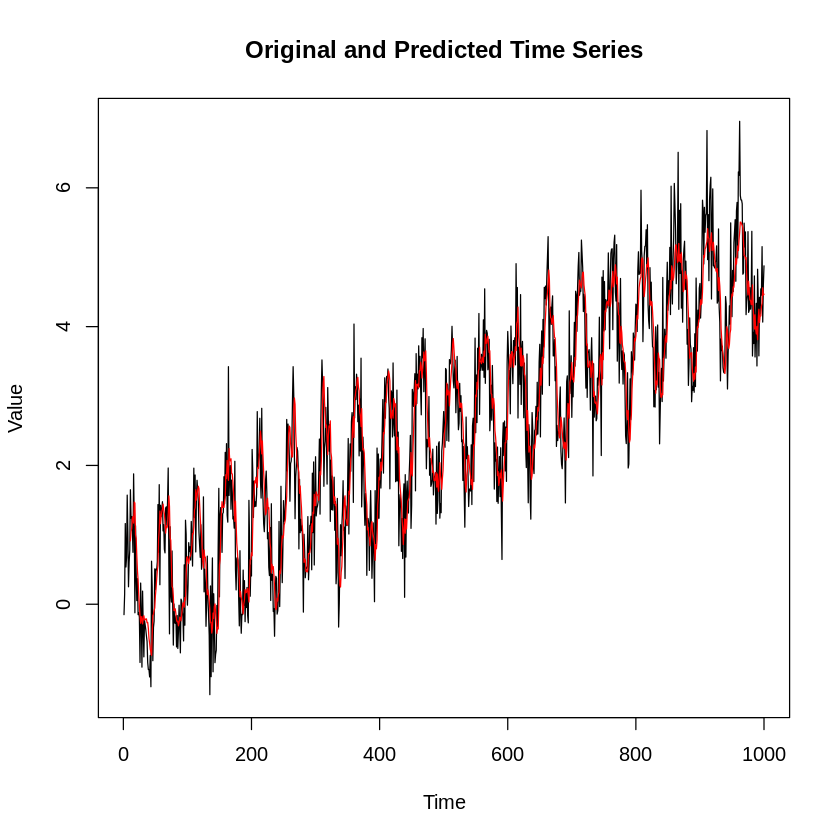

In [64]:
pred_val <- model %>% predict(x_data)

# Plotting
par(mfrow = c(1, 1))
plot(x, data, type="l", xlab="Time", ylab="Value", main="Original and Predicted Time Series")
lines(11:1000, pred_val, col="red")